<a href="https://colab.research.google.com/github/Alfonso-Jesus-Garcia-Moya/APRENDIZAJE_NO_SUPERVISADO/blob/main/Semana_6%20CON%20TAREA%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TAREA DE SEMANA 6 CON:
### (Tema 3 — Aprendizaje no supervisado)


In [1]:
# ============================================
# 0) Setup básico
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.neighbors import NearestNeighbors

import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)
plt.rcParams["figure.figsize"] = (7, 5)


## 1 EDA mínimo para clustering (Dataset: Iris



In [2]:
# ============================================
# 1) Carga de datos (Iris) y preparación
# ============================================
iris = load_iris(as_frame=True)
X = iris.data.copy()          # Solo features (no usamos etiquetas para no supervisado)
feature_names = X.columns.tolist()

print("Shape:", X.shape)
display(X.head())

# Estadísticas básicas
display(X.describe())


Shape: (150, 4)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


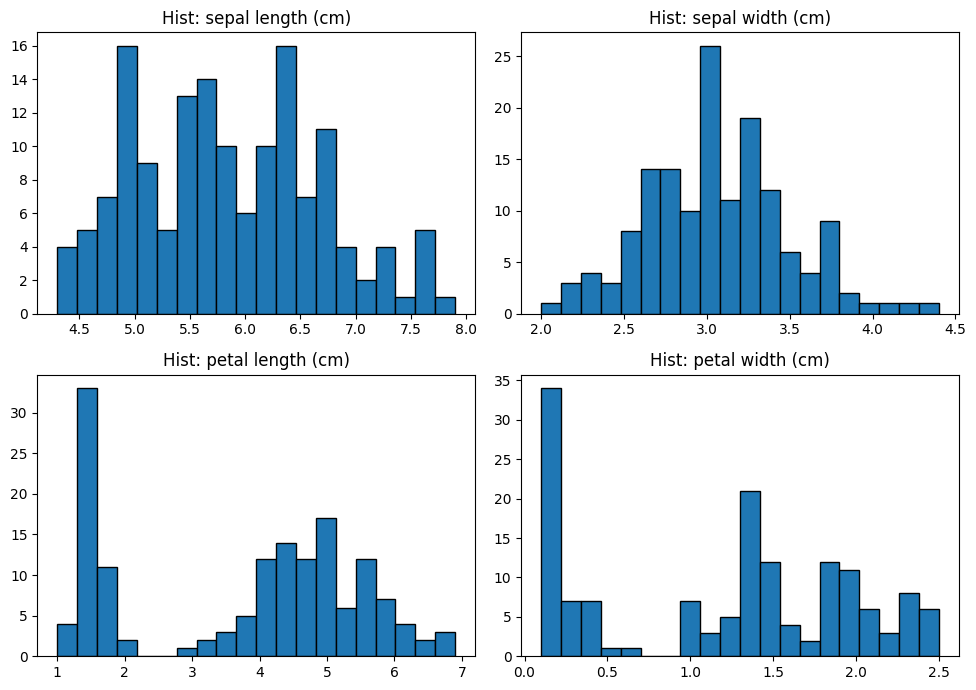

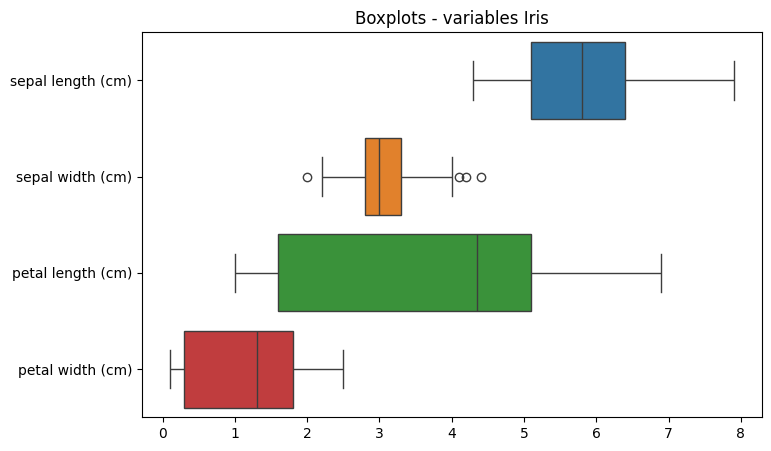

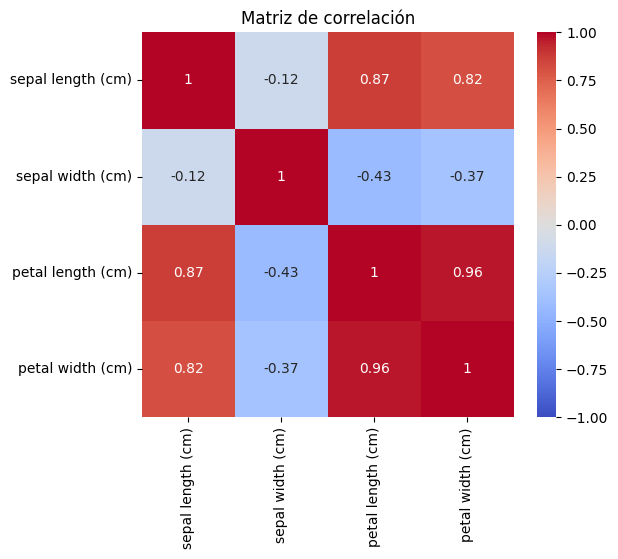

In [3]:
# ============================================
# 2) EDA mínimo (distribuciones, boxplots, correlaciones)
# ============================================

fig, axes = plt.subplots(2, 2, figsize=(10,7))
axes = axes.ravel()
for i, col in enumerate(feature_names):
    axes[i].hist(X[col], bins=20, edgecolor="k")
    axes[i].set_title(f"Hist: {col}")
plt.tight_layout()
plt.show()

# Boxplots
plt.figure(figsize=(8,5))
sns.boxplot(data=X, orient="h")
plt.title("Boxplots - variables Iris")
plt.show()

# Correlación
plt.figure(figsize=(6,5))
sns.heatmap(X.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Matriz de correlación")
plt.show()


Varianza explicada PCA2: [0.73  0.229]
Varianza explicada PCA3: [0.73  0.229 0.037]


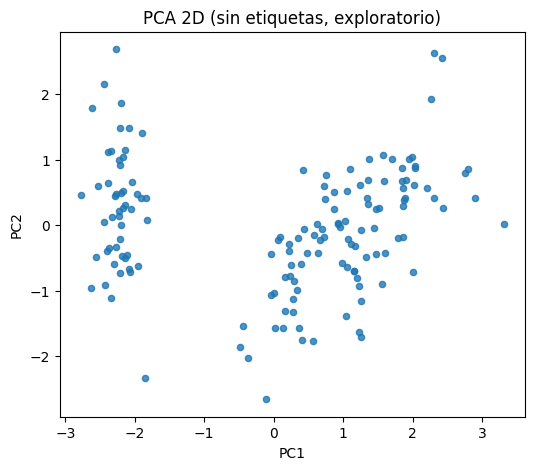

In [4]:
# ============================================
# 3) Escalado + PCA preliminar (visual exploratoria)
# ============================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(X_scaled)

pca3 = PCA(n_components=3, random_state=42)
X_pca3 = pca3.fit_transform(X_scaled)

print("Varianza explicada PCA2:", pca2.explained_variance_ratio_.round(3))
print("Varianza explicada PCA3:", pca3.explained_variance_ratio_.round(3))

plt.figure(figsize=(6,5))
plt.scatter(X_pca2[:,0], X_pca2[:,1], s=20, alpha=0.8)
plt.title("PCA 2D (sin etiquetas, exploratorio)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()


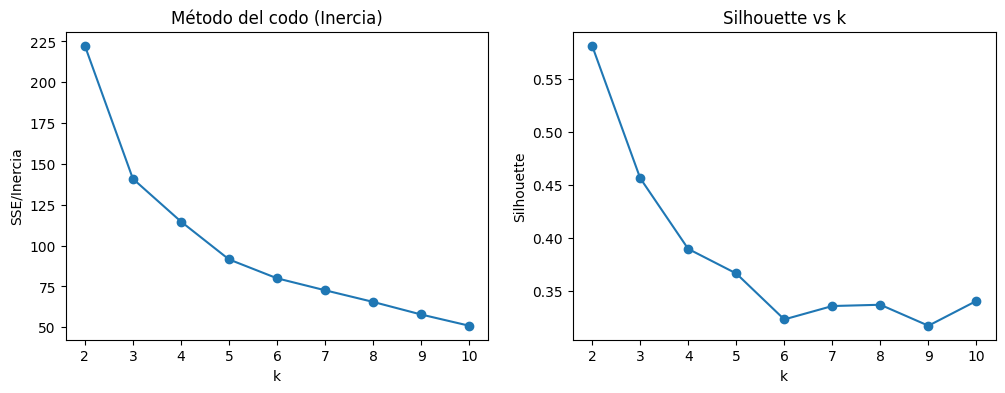

✔ k óptimo por silhouette: 2 | silhouette=0.582


In [5]:
# ============================================
# 4) Selección de k para K-means (Elbow + Silhouette)
# ============================================
inertias = []
sil_scores = []
ks = range(2, 11)

for k in ks:
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(ks, inertias, marker="o")
ax[0].set_title("Método del codo (Inercia)")
ax[0].set_xlabel("k"); ax[0].set_ylabel("SSE/Inercia")

ax[1].plot(ks, sil_scores, marker="o")
ax[1].set_title("Silhouette vs k")
ax[1].set_xlabel("k"); ax[1].set_ylabel("Silhouette")
plt.show()

k_opt = ks[int(np.argmax(sil_scores))]
print(f"✔ k óptimo por silhouette: {k_opt} | silhouette={max(sil_scores):.3f}")


[K-means k=2] silhouette=0.582 | CH=251.3 | DB=0.593


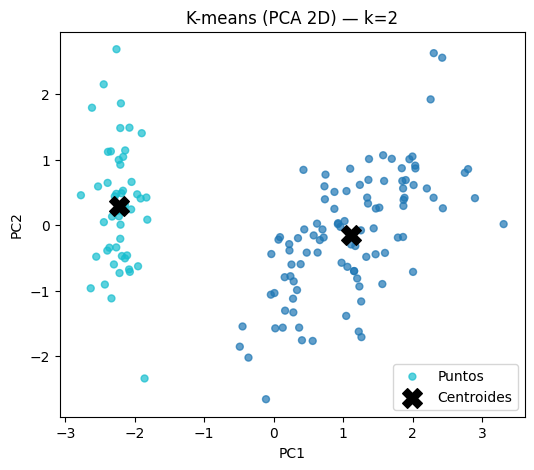

Centroides (escala original):


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
Cluster 0,6.26,2.87,4.91,1.68
Cluster 1,5.01,3.43,1.46,0.25


In [7]:
k_fixed = 2  # <— prueba con 3 (o el que quieras)

kmeans = KMeans(n_clusters=k_fixed, random_state=42)
labels_km = kmeans.fit_predict(X_scaled)

sil_km = silhouette_score(X_scaled, labels_km) #Mide qué tan similar es un punto a su propio cluster (cohesión) comparado con otros clusters
ch_km  = calinski_harabasz_score(X_scaled, labels_km)#Es la razón entre la dispersión entre clusters y la dispersión dentro de los clusters.
db_km  = davies_bouldin_score(X_scaled, labels_km)
print(f"[K-means k={k_fixed}] silhouette={sil_km:.3f} | CH={ch_km:.1f} | DB={db_km:.3f}")

# ---- Proyección de los centroides a PCA 2D ----
centers_scaled = kmeans.cluster_centers_
centers_pca = pca2.transform(centers_scaled)  # proyectamos centroides al espacio PCA 2D

plt.figure(figsize=(6,5))
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=labels_km, cmap="tab10", s=25, alpha=0.7, label="Puntos")
plt.scatter(centers_pca[:,0], centers_pca[:,1], c="black", marker="X", s=200, label="Centroides")
plt.title(f"K-means (PCA 2D) — k={k_fixed}")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend()
plt.show()

# ---- Centroides en escala original ----
centers_orig = scaler.inverse_transform(centers_scaled)
centers_df = pd.DataFrame(centers_orig, columns=feature_names)
centers_df.index = [f"Cluster {i}" for i in range(k_fixed)]
print("Centroides (escala original):")
display(centers_df.round(2))

# ---- Perfilado de clusters ----
df_km = X.copy()
df_km["cluster_km"] = labels_km
profile_km = df_km.groupby("cluster_km").mean().round(2)


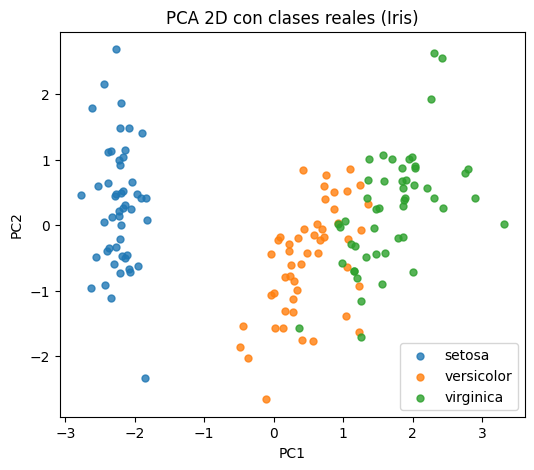

In [8]:
# ============================================
# EXTRA: Visualización PCA con etiquetas reales
# ============================================

y_true = iris.target  # etiquetas reales (Setosa=0, Versicolor=1, Virginica=2)
target_names = iris.target_names

plt.figure(figsize=(6,5))
for i, target in enumerate(np.unique(y_true)):
    plt.scatter(
        X_pca2[y_true == target, 0],
        X_pca2[y_true == target, 1],
        label=target_names[i],
        s=25, alpha=0.8
    )

plt.title("PCA 2D con clases reales (Iris)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend()
plt.show()


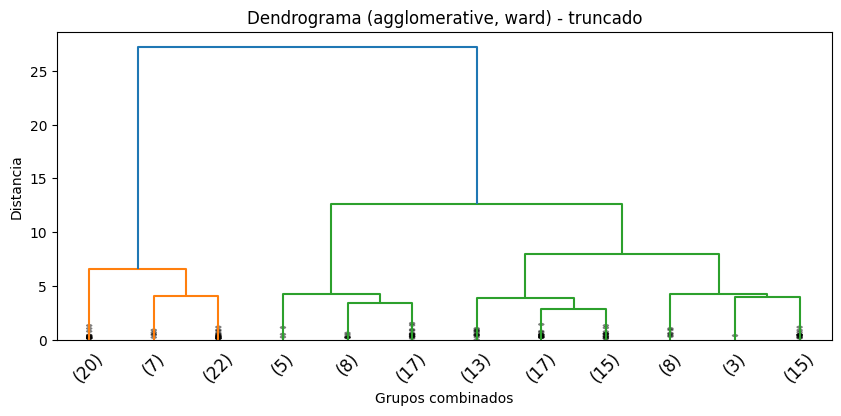

[Jerárquico/Ward] silhouette=0.577 | Calinski-Harabasz=240.2 | Davies-Bouldin=0.592


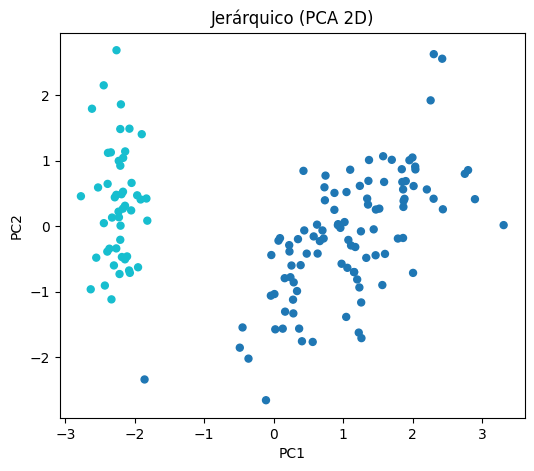

In [9]:
# ============================================
# 6) Agrupamiento jerárquico: dendrograma + etiquetas
# ============================================
# Dendrograma (usamos linkage sobre datos escalados)
Z = linkage(X_scaled, method="ward")
plt.figure(figsize=(10,4))
dendrogram(Z, truncate_mode="lastp", p=12, leaf_rotation=45., show_contracted=True)
plt.title("Dendrograma (agglomerative, ward) - truncado")
plt.xlabel("Grupos combinados"); plt.ylabel("Distancia")
plt.show()

# Cortar en n_clusters = k_opt para comparar con K-means
agg = AgglomerativeClustering(n_clusters=2, linkage="ward")
labels_agg = agg.fit_predict(X_scaled)

sil_agg = silhouette_score(X_scaled, labels_agg)
ch_agg  = calinski_harabasz_score(X_scaled, labels_agg)
db_agg  = davies_bouldin_score(X_scaled, labels_agg)
print(f"[Jerárquico/Ward] silhouette={sil_agg:.3f} | Calinski-Harabasz={ch_agg:.1f} | Davies-Bouldin={db_agg:.3f}")

plt.figure(figsize=(6,5))
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=labels_agg, cmap="tab10", s=25)
plt.title("Jerárquico (PCA 2D)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()


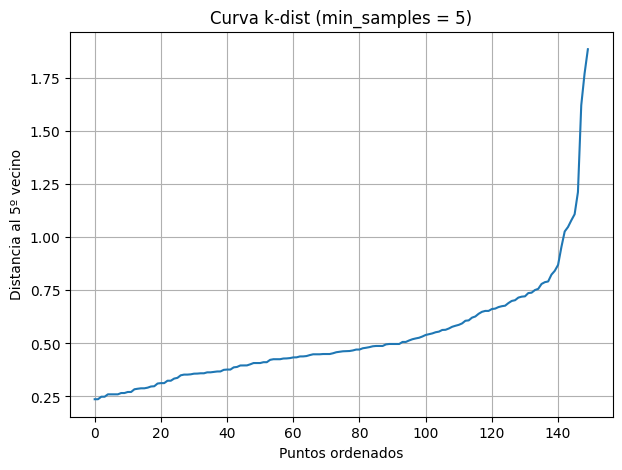

Clusters encontrados (sin contar ruido): 2
Silhouette (sin ruido): 0.656
Calinski-Harabasz (sin ruido): 344.0
Davies-Bouldin (sin ruido): 0.494


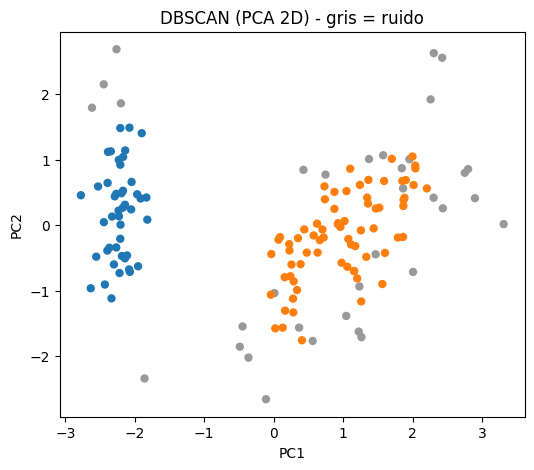

In [14]:
# ============================================
# 7) DBSCAN: versión simple para clase (CORREGIDA)
# ============================================

min_samples = 5
neigh = NearestNeighbors(n_neighbors=min_samples)
neigh.fit(X_scaled)
distances, _ = neigh.kneighbors(X_scaled)
k_dist = np.sort(distances[:, -1])  # Distancia al 5º vecino

plt.plot(k_dist)
plt.title("Curva k-dist (min_samples = 5)")
plt.xlabel("Puntos ordenados")
plt.ylabel("Distancia al 5º vecino")
plt.grid(True)
plt.show()

# Elige visualmente un valor de corte (ej: 0.5)
eps = 0.5  # (puede ajustarse según la curva anterior)

# --- PASO 2: Aplicar DBSCAN ---
db = DBSCAN(eps=eps, min_samples=min_samples)
labels_db = db.fit_predict(X_scaled)

# --- PASO 3: Evaluar y Asignar Métricas (CORRECCIÓN) ---
n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
print(f"Clusters encontrados (sin contar ruido): {n_clusters}")

# Inicializar métricas para evitar NameError
sil_db, ch_db, db_db = np.nan, np.nan, np.nan

mask = labels_db != -1
if n_clusters >= 2:
    # Calcular y asignar a las variables que usa el Paso 8
    sil_db = silhouette_score(X_scaled[mask], labels_db[mask])
    ch_db  = calinski_harabasz_score(X_scaled[mask], labels_db[mask])
    db_db  = davies_bouldin_score(X_scaled[mask], labels_db[mask])

    print(f"Silhouette (sin ruido): {sil_db:.3f}")
    print(f"Calinski-Harabasz (sin ruido): {ch_db:.1f}")
    print(f"Davies-Bouldin (sin ruido): {db_db:.3f}")
else:
    print("No hay suficientes clusters para calcular métricas.")

# --- PASO 5: Visualización (PCA 2D) ---
plt.figure(figsize=(6, 5))
colors = [
    sns.color_palette("tab10")[l % 10] if l != -1 else (0.6, 0.6, 0.6)
    for l in labels_db
]
plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c=colors, s=25)
plt.title("DBSCAN (PCA 2D) - gris = ruido")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


[GMM k=3] silhouette=0.582 | Calinski-Harabasz=251.3 | Davies-Bouldin=0.593


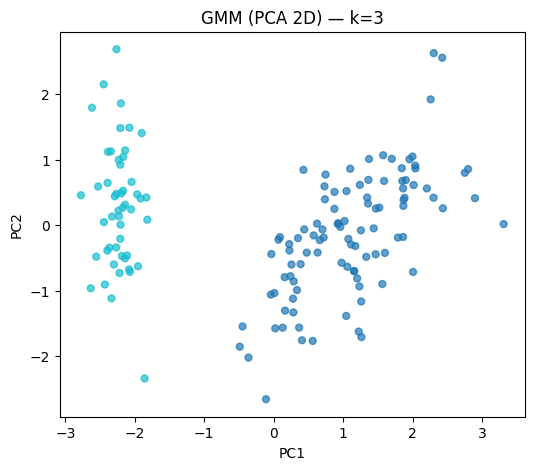

,k,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,3,0.58175,251.349339,0.593313


In [15]:
from sklearn.mixture import GaussianMixture

# ============================================
# 8) Gaussian Mixture Models (GMM) flexible (sin funciones)
# ============================================

resultados = []

# Probar con k=2 y k=3
for k in [3]:
    # Entrenar el modelo
    gmm = GaussianMixture(n_components=2, covariance_type="full", random_state=42)
    labels_gmm = gmm.fit_predict(X_scaled)

    # Calcular métricas
    sil_gmm = silhouette_score(X_scaled, labels_gmm)
    ch_gmm  = calinski_harabasz_score(X_scaled, labels_gmm)
    db_gmm  = davies_bouldin_score(X_scaled, labels_gmm)

    resultados.append([k, sil_gmm, ch_gmm, db_gmm])

    print(f"[GMM k={k}] silhouette={sil_gmm:.3f} | Calinski-Harabasz={ch_gmm:.1f} | Davies-Bouldin={db_gmm:.3f}")

    # Visualización PCA 2D
    plt.figure(figsize=(6,5))
    plt.scatter(X_pca2[:,0], X_pca2[:,1], c=labels_gmm, cmap="tab10", s=25, alpha=0.7)
    plt.title(f"GMM (PCA 2D) — k={k}")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.show()

# Tabla resumen
resumen = pd.DataFrame(resultados, columns=["k", "Silhouette", "Calinski-Harabasz", "Davies-Bouldin"])
display(resumen)


In [16]:
# ============================================
# 8) Comparación de métodos (resumen métricas)
# ============================================
rows = []
# K-means
# Silhouette: entre -1 y 1 (mejor cerca de 1) - mide separación y cohesión
# Calinski-Harabasz: mayor es mejor - relación entre dispersión entre clústeres vs dentro
# Davies-Bouldin: menor es mejor - mide la similitud entre clústeres
# K-means
rows.append(["K-means", k_opt, sil_km, ch_km, db_km])

# Jerárquico
rows.append(["Jerárquico/Ward", len(np.unique(labels_agg)), sil_agg, ch_agg, db_agg])

# DBSCAN
if (labels_db != -1).any() and len(np.unique(labels_db[labels_db != -1])) >= 2:
    rows.append([
        "DBSCAN (no-ruido)",
        len(np.unique(labels_db)) - (1 if -1 in labels_db else 0),
        sil_db, ch_db, db_db
    ])
else:
    rows.append(["DBSCAN (no-ruido)", 0, np.nan, np.nan, np.nan])

# GMM
rows.append([
    "Gaussian Mixture Model",
    len(np.unique(labels_gmm)),
    sil_gmm, ch_gmm, db_gmm
])

# Crear DataFrame resumen
summary = pd.DataFrame(
    rows,
    columns=["Método", "n_clusters", "Silhouette", "Calinski-Harabasz", "Davies-Bouldin"]
)
display(summary)


,Método,n_clusters,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,K-means,2,0.581750,251.349339,0.593313
1,Jerárquico/Ward,2,0.577035,240.245665,0.591656
2,DBSCAN (no-ruido),2,0.655889,343.968085,0.494216
3,Gaussian Mixture Model,2,0.581750,251.349339,0.593313


In [17]:
# ============================================
# 9) Notas de interpretación (impreso como guía)
# ============================================
print(
"""Guía rápida de lectura:
- Silhouette más alto → mejor separación (≈1 ideal, <0 indica solapamiento).
- Calinski–Harabasz más alto → clusters más densos y bien separados.
- Davies–Bouldin más bajo → mejor (menor intra/inter relación).

Sugerencias:
1) Verifica si el k recomendado por silhouette también tiene sentido al perfilar las variables (centroides / medias por cluster).
2) Si la forma de los datos no es esférica, DBSCAN o Jerárquico pueden capturar mejor la estructura.
3) No 'reifiques' los clusters: son una forma útil de resumir, no necesariamente clases reales.
"""
)


Guía rápida de lectura:
- Silhouette más alto → mejor separación (≈1 ideal, <0 indica solapamiento).
- Calinski–Harabasz más alto → clusters más densos y bien separados.
- Davies–Bouldin más bajo → mejor (menor intra/inter relación).

Sugerencias:
1) Verifica si el k recomendado por silhouette también tiene sentido al perfilar las variables (centroides / medias por cluster).
2) Si la forma de los datos no es esférica, DBSCAN o Jerárquico pueden capturar mejor la estructura.
3) No 'reifiques' los clusters: son una forma útil de resumir, no necesariamente clases reales.



BIBLIOGRAFIA DE DATASET

Fisher, R. A. (1936). The use of multiple measurements in taxonomic problems. Annals of Eugenics, 7(2), 179–188.


Anderson, E. (1936). The species problem in Iris. Annals of the Missouri Botanical Garden, 23(3), 457–509.

Libros

https://github.com/Benlau93/Data-Science-Curriculum/blob/master/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf

https://esl.hohoweiya.xyz/book/The%20Elements%20of%20Statistical%20Learning.pdf


https://www.ic.unicamp.br/~wainer/cursos/1s2021/432/2013_Book_AppliedPredictiveModeling.pdf